# Think Bayes: Chapter 14

This notebook presents code and exercises from Think Bayes, second edition.

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
from __future__ import print_function, division

%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from collections import Counter
from itertools import product
from IPython.display import display
from scipy import stats
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import mythinkbayes as mtb
import numpy as np
import pandas as pd
import pdb

'Done'

'Done'

## Geiger Counter Problem

Variables

- $r$: average rate at which some source emits particles (particles / second).
- $n$: number of particles emitted (particles / second).
- $f$: the fraction of particles counted by a counter (e.g. 10 %)
- $k$: the number of particles that were counted.

Distributions

- $n$ is Poisson-distributed with parameter $r$. This gets more complicated if $r$ is a distribution, but still doable.
- $k$ is Binomial-distributed with parameters $n$ and $f$.

Forward and Inverse Problems

- Forward problem: given the parameters of the system, find the distribution of the data.
- Inverse problem: given the data, find the distributions of the parameters.

Simple Model

- Assume we know fixed values of $r$ and $f$.
- Estimate $n$.

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 1.9 ms
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 1.75 ms
CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 1.77 ms


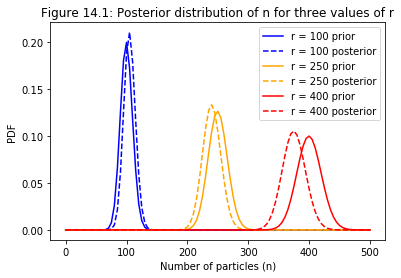

In [2]:
class SimpleCounter(mtb.PMF):
    
    def __init__(self, r, f, N):
        
        # SimpleCounter represents the distribution of n,
        # the number of particles emitted. This starts with
        # a Poisson prior with parameter r.
        hypos = N
        probs = stats.poisson.pmf(hypos, mu=r)
        super().__init__(hypos, probs)
        
        self.r = r
        self.f = f
        
    def update(self, data, normalize=True):
        """Vectorized update function. ~20x faster than using the looping update.
        
        The likelihood P(data | hypo) is the Binomial probability that *data* particles
        were counted using a counter with accuracy *self.f* given *hypo* particles emitted.
        
        The scipy stats library lets you comptue the Binomial PMF for all values of N
        in one call. This is the "vectorized" part that spees things up.
        
        I left the slower likelihood function for comparison.
        
        # Arguments:
            data: number of particles counted.
            normalize: whether to normalize before returning.
        
        # Returns:
            self
        
        """
        
        k = data
        N = self.hypos
        p = self.f
        
        Like = stats.binom.pmf(k, N, p)
        self[:] *= Like
        
        if normalize:
            return self.normalize()
        return self
        
    def likelihood(self, data, hypo):
        """P(data | hypo) is the Binomial probability that *data* particles
        were counted given *hypo* particles emitted and Binomial parameter
        self.f (can be interpretted as accuracy of the counter).
        
        # Arguments:
            data: number of particles detected.
            hypo: hypothetical number of particles emitted.
        
        # Returns:
            like: scalar likelihood.
        """
        k = data
        n = hypo
        p = self.f
        return stats.binom.pmf(k, n, p)
        
        
# Test the model for a fixed f, fixed data, and variable r.
f = 0.1
k = 15
N = np.arange(0, 501, 5)

for r, c in zip([100, 250, 400], ['blue', 'orange', 'red']):
    sc = SimpleCounter(r, f, N)
    sc.plot(label='r = %d prior' % r, color=c)
    %time sc.update(k)
    sc.plot(label='r = %d posterior' % r, color=c, linestyle='--')
    
plt.title('Figure 14.1: Posterior distribution of n for three values of r')
plt.xlabel('Number of particles (n)')
plt.ylabel('PDF')
plt.legend()
plt.show()

## Make it hierarchical

Changes

- No longer assuming a fixed value for $r$, but rather a distribution of values for $r$, with a `SimpleCounter` object corresponding to each value of $r$.

CPU times: user 96 ms, sys: 0 ns, total: 96 ms
Wall time: 95.4 ms
CPU times: user 184 ms, sys: 4 ms, total: 188 ms
Wall time: 191 ms


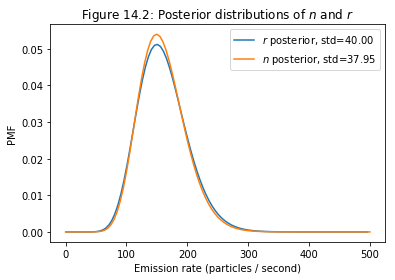

In [3]:
class EmissionRate(mtb.PMF):
    """Models r and n based on counters, one counter for each value of r.
    
    # Arguments:
        R: a range of values for r.
        N: a range of values for n.
        f: the proportion of particles counted by a counter.
    """
    
    def __init__(self, R, N, f=0.1):
        
        # Start with a uniform distribution over R values.
        # Downey simply makes the counter objects his hypotheses, but
        # PMF inherits from pandas.Series, and pandas.Series doesn't 
        # support using objects for the index.
        super().__init__(R)
        
        # Keep a counter for each value of r in a dict.
        self.counters = {r: SimpleCounter(r, f, N) for r in R}
        
    @property
    def n(self):
        """Return the distribution of n, which is a mixture over the counters'
        distributions of n weighted by each counter's probability."""
        pmfs = [(self.counters[r], prob) for r, prob in self.items()]
        return mtb.PMF.from_mixture(pmfs)
    
    def likelihood(self, data, hypo):
        """P(data | hypo) = P(counted k particles | emission rate r).
        
        The likelihood that gets returned is the sum of the unnormalized posterior
        from updating the counter corresponding to r.
        """
        
        k = data
        r = hypo
        
        # Update the counter without normalizing and get its sum.
        like = self.counters[r].update(k, normalize=False).sum()
        
        # Now normalize the counter.
        self.counters[r].normalize()
        
        return like
            
%time er = EmissionRate(R=np.arange(1, 501, 5), N=np.arange(0, 501, 5), f=0.1)
%time er.update(15)

er.plot(label='$r$ posterior, std=%.2lf' % np.sqrt(er.var()))

n = er.n
n.plot(label='$n$ posterior, std=%.2lf' % np.sqrt(n.var()))

plt.xlabel('Emission rate (particles / second)')
plt.ylabel('PMF')
plt.title('Figure 14.2: Posterior distributions of $n$ and $r$')
plt.legend()
plt.show()

A note on Downey's interpretation of the posteriors.

> The posterior distributions of r and n are similar; the only difference is that
we are slightly less certain about n. In general, we can be more certain about the
long-range emission rate, r, than about the number of particles emitted in any
particular second, n.

The plot and the variance measured on both posteriors seem to contradict Downey's
interpretation. $n$ has standard deviation $\sigma(n) \approx 37.95$, while $\sigma(r) \approx 40$.
This would indicate we are actually *more* certain about $n$ than $r$. However, he
seems to have left out this example entirely in the ThinkBayes2 repository, so maybe
there were other problems as well.

## Exercises

**Exercise 14.1**:

This exercise is also inspired by an example in Jaynes, Probability Theory.

Suppose  you  buy  a  mosquito  trap  that  is  supposed  to  reduce  the  population  of
mosquitoes near your house.  Each week, you empty the trap and count the num-
ber of mosquitoes captured.  After the first week, you count 30 mosquitoes.  After
the second week, you count 20 mosquitoes.  Estimate the percentage change in the
number of mosquitoes in your yard.

To answer this question, you have to make some modeling decisions. Here are some
suggestions:

1. Suppose that each week a large number of mosquitoes, $n$, is bred in a wetland near your home.
2. During the week, some fraction of them,  $f_1$, wander into your yard, and of those some fraction, $f_2$, are caught in the trap. The number of trapped mosquitos is $k$, and is computed: $k = n \times f_1 \times f_2$.
3. Your solution should take into account your prior belief about how much N is likely to change from one week to the next.  You can do that by adding a level to the hierarchy to model the percent change in $n$.

**Trivial Model**

- Assume $f_1$ and $f_2$ are fixed.
- Compute $N$ for weeks 1 and 2 to match 30 and 20, respectively.
- Compute the percentage change, $d$.

This model takes two counts from the trap (30 and 20) and estimates a single weekly percentage change. To expand on this, we'll have to compute a *distribution* over weekly percentage changes based on some prior assumptions about how $N$ changes.

In [4]:
f1 = 0.5   # Fraction entering yard.
f2 = 0.5   # Fraction caught in trap.

# Week 1. Solve for N: N * f1 * f2 = 30
k = 30
n = k / f1 / f2
y1 = n * f1
print('Week 1, mosquitos in yard = %d' % y1)

# Week 2. Solve for N: N * f1 * f2 = 20
k = 20
n = k / f1 / f2
y2 = n * f1
print('Week 2, mosquitos in yard = %d' % y2)

d = (y2 - y1) / y1
print('Percentage change = %.2lf' % (d * 100))

Week 1, mosquitos in yard = 60
Week 2, mosquitos in yard = 40
Percentage change = -33.33


**Implement a Counter**

- Given a value of $k$, estimate a distribution over $N$.
- Similar to the `SimpleCounter` implemented above, the likelihood of a value $k$ under hypothesis $n$ is the binomial probability with $p = f_1 \times f_2$.
- A fixed value for $d$ can then be estimated by doing arithmetic on the week 1 and week 2 posteriors. This value approximates the one computed above.

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 2.96 ms
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 2.48 ms


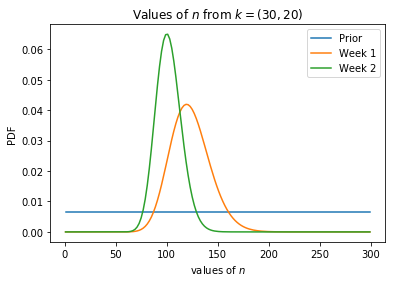

Percentage change = -33.61


In [5]:
class MosquitoCount(mtb.PMF):
    
    def __init__(self, N, f1, f2):
        super().__init__(N)
        self.p = f1 * f2

    def update(self, data, normalize=True):
        """Vectorized update"""
        k = data
        N = self.hypos
        Like = stats.binom.pmf(k, N, self.p)
        self[:] *= Like
        if normalize:
            return self.normalize()
        else:
            return self
        
    def likelihood(self, data, hypo):
        """P(data | hypo) = P(t | N)"""
        k = data
        n = hypo
        return stats.binom.pmf(k, n, self.p)
        
k1, k2 = K = [30, 20]
N = np.arange(1, 301, 2)
f1 = 0.5
f2 = 0.5

n = MosquitoCount(N, f1, f2)
n.plot(label='Prior')

%time n1 = n.update(k1).copy()
n.plot(label='Week 1')

%time n2 = n.update(k2).copy()
n.plot(label='Week 2')

plt.title('Values of $n$ from $k = (%d, %d)$' % (k1, k2))
plt.xlabel('values of $n$')
plt.ylabel('PDF')
plt.legend()
plt.show()

d = (n2 - n1) / n1
d_MAP, _ = d.MAP()
d_MAP /= f2
print('Percentage change = %.2lf' % (d_MAP * 100))

**Add $d$ to the hierarchy**

- Similar to the `EmissionRate` class above, we now introduce a prior for $d$ and update it based on the observed values $k_1$ and $k_2$.
- A somewhat tricky element of this model is that the likelihood needs to be the unnormalized posterior of $n$ after updating with $k_1$ and $k_2$.
- Again, the percentage change centers right around -33%. However, this happens without having to divide by $f_2$.. I'm not sure how to explain this. Perhaps it has to do with the fact that I'm applying $d$ to $n$ and not to $n \times f_1$.

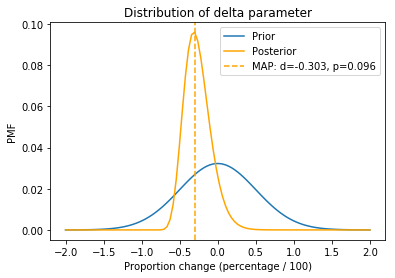

In [6]:
class MosquitoDelta(mtb.PMF):
    """
    
    # Arguments:
        D: possible values for parameter d (delta).
        N: possible values for parameter n (number of mosquitos).
        f1: fraction of n coming into yard.
        f2: fraction of mosquitos in yard getting trapped.
    
    """
    def __init__(self, D_hypos, D_priors, N, f1, f2):
        super().__init__(D_hypos, D_priors)
        self.mc_params = (N, f1, f2)
    
    def likelihood(self, data, hypo):
        """P(data | hypo) = P((k1, k2) | d)
        
        # Arguments:
            data: (k1, k2), the two numbers of mosquitos found on the trap.
            hypo: d, the hypothesized delta value.
            
        # Returns:
            like: scalar likelihood.
        """
        
        k1, k2 = data
        d = hypo
        
        # Instantiate a distribution over variable n.
        n = MosquitoCount(*self.mc_params)
        
        # Update using the first count.
        n.update(k1)
        
        # Increment or decrement n by the hypothesized delta.
        # d = (n2 - n1) / n1
        # n2 = n1 + n1 * d
        n.index += n.index * d
        
        # Update using the second count. This time do not normalize.
        n.update(k2, normalize=False)
        
        # Return the unnormalized posterior.
        return n.sum()
    
k1, k2 = K = [30, 20]
f1, f2 = 0.5, 0.5
N = np.arange(1, 301, 1)
D_hypos = np.linspace(-2, 2, 100)
D_probs = stats.norm.pdf(D_hypos, 0, 0.5)

d = MosquitoDelta(D_hypos, D_probs, N, f1, f2)
d.plot(label='Prior')

d.update(K)
d.plot(label='Posterior', color='orange')

x, p = d.MAP()
plt.axvline(x, label='MAP: d=%.3lf, p=%.3lf' % (x, p), color='orange', linestyle='--')

plt.title('Distribution of delta parameter')
plt.xlabel('Proportion change (percentage / 100)')
plt.ylabel('PMF')
plt.legend()
plt.show()